In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
from admm.agents import FedConsensus
from admm.servers import EventADMM
from admm.models import FCNet, CNN
from admm.utils import average_params
from admm.data import partition_data, split_dataset
import seaborn as sns
sns.set_theme()

%matplotlib inline

In [2]:
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_trainset = datasets.CIFAR10(
    root='./data/cifar10', train=True,
    download=True, transform=cifar_transform
)
cifar_testset = datasets.CIFAR10(
    root='./data/cifar10', train=False,
    download=True, transform=cifar_transform
)

mnist_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.Lambda(lambda x: torch.flatten(x))
])

mnist_trainset = datasets.MNIST(
    root='./data/mnist_data', train=True,
    download=True, transform=mnist_transform
)
mnist_testset = datasets.MNIST(
    root='./data/mnist_data', train=False,
    download=True, transform=mnist_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_dataset, val_dataset, _ = split_dataset(dataset=mnist_trainset, train_ratio=0.8, val_ratio=0.2)

trainsets = partition_data(
    num_clients=100,
    iid=False,
    balance=True,
    power_law=False,
    seed=42,
    trainset=train_dataset.dataset,
    labels_per_partition=1
)

for i, dataset in enumerate(trainsets):
    labels = np.zeros(10)
    loader = DataLoader(dataset, batch_size=1)
    for data, target in loader:
        labels[target.item()] += 1
    print(f'Dataset {i} distribution: {labels} - num_samples = {labels.sum()}')

labels = np.zeros(10)
loader = DataLoader(val_dataset, batch_size=1)
for data, target in loader:
    labels[target.item()] += 1
print(f'Validation dataset {i} distribution: {labels} - num_samples = {labels.sum()}')

oader = DataLoader(val_dataset, batch_size=10)
for data, target in loader:
    print(data.shape)
    break

Dataset 0 distribution: [  0.   0. 271.   0.   0.   0.   0. 271.   0.   0.] - num_samples = 542.0
Dataset 1 distribution: [  0.   0.   0. 271.   0.   0.   0.   0.   0. 271.] - num_samples = 542.0
Dataset 2 distribution: [  0.   0. 542.   0.   0.   0.   0.   0.   0.   0.] - num_samples = 542.0
Dataset 3 distribution: [271.   0.   0. 271.   0.   0.   0.   0.   0.   0.] - num_samples = 542.0
Dataset 4 distribution: [  0.   0. 271.   0.   0.   0.   0.   0. 271.   0.] - num_samples = 542.0
Dataset 5 distribution: [  0.   0.   0.   0. 271. 271.   0.   0.   0.   0.] - num_samples = 542.0
Dataset 6 distribution: [  0.   0. 271.   0.   0.   0.   0.   0. 271.   0.] - num_samples = 542.0
Dataset 7 distribution: [  0.   0.   0. 271.   0.   0.   0. 271.   0.   0.] - num_samples = 542.0
Dataset 8 distribution: [  0.   0.   0.   0.   0.   0.   0.   0. 271. 271.] - num_samples = 542.0
Dataset 9 distribution: [  0.   0.   0.   0. 271. 271.   0.   0.   0.   0.] - num_samples = 542.0
Dataset 10 distribut

In [4]:
batch_size = 32
train_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in trainsets]
test_loader = DataLoader(mnist_testset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [13]:
lr = 0.001
deltas = [1e-6, 3e-6, 6e-6, 1e-5, 1.5e-5, 0]
rho = 0.01
rhos = [0.0001, 0.001, 0.01, 0.1, 1]
t_max = 100
loaders = train_loaders
device = 'cpu'

acc_per_delta = np.zeros((len(deltas), t_max))
rate_per_delta = np.zeros((len(deltas), t_max))
loads = []
test_accs = []

print(f'N = {len(loaders)}')
_N = 0
for loader in loaders:
    _N += len(loader.dataset)

global_model = FCNet(in_channels=784, hidden1=200, hidden2=None, out_channels=10)
global_params =  [val.cpu().numpy() for _, val in global_model.state_dict().items()]

for i, delta in enumerate(deltas):
    
    agents = []
    for loader in loaders:
        torch.manual_seed(78)
        model = FCNet(in_channels=784, hidden1=200, hidden2=None, out_channels=10)
        agents.append(
            FedConsensus(
                N=len(loaders),
                delta=delta,
                rho=rho,
                model=model,
                loss=nn.CrossEntropyLoss(),
                train_loader=loader,
                epochs=1,
                data_ratio=len(loader.dataset)/_N,
                device=device,
                lr=lr
            ) 
        )
    

    # Broadcast average to all agents and check if equal
    for agent in agents:
        agent.primal_avg = average_params([agent.model.parameters() for agent in agents])
    
    # Check that all agents start with same params
    for agent1 in agents:
        for agent2 in agents:
            for param1, param2 in zip(agent1.model.parameters(), agent2.model.parameters()):
                if not torch.equal(param1, param2): raise ValueError("Initial params aren't equal")
    
    # Check to make sure they all start with the same average
    for agent1 in agents:
        for agent2 in agents:
            for param1, param2 in zip(agent1.primal_avg, agent2.primal_avg):
                if not torch.equal(param1, param2): raise ValueError("Averaged params aren't equal")
                if torch.equal(param1, torch.zeros(param1.shape)) or torch.equal(param2, torch.zeros(param1.shape)):
                    raise ValueError('Averaged Params are zero')
    print('Parameter check complete!')

    # Run consensus algorithm
    server = EventADMM(clients=agents, t_max=t_max)
    server.spin(loader=val_loader)
    
    # For plotting purposes
    acc_per_delta[i,:] = server.val_accs
    rate_per_delta[i,:] = server.rates
    loads.append(server.comm)
    accs = server.validate(loader=test_loader)
    test_accs.append(sum(accs)/len(accs))

N = 100
Parameter check complete!


Comm: 1.000, Min: 0.90916667, Max: 0.91975000, Avg Acc: 0.91568500, min Delta: 0.00000691, max Delta: 0.00001476, avg: 0.00001176: 100%|██████████| 100/100 [17:06<00:00, 10.27s/it]


Parameter check complete!


Comm: 0.569, Min: 0.10550000, Max: 0.40375000, Avg Acc: 0.25753833, min Delta: 0.00001093, max Delta: 0.00002013, avg: 0.00001426:  41%|████      | 41/100 [07:08<10:16, 10.45s/it]


KeyboardInterrupt: 

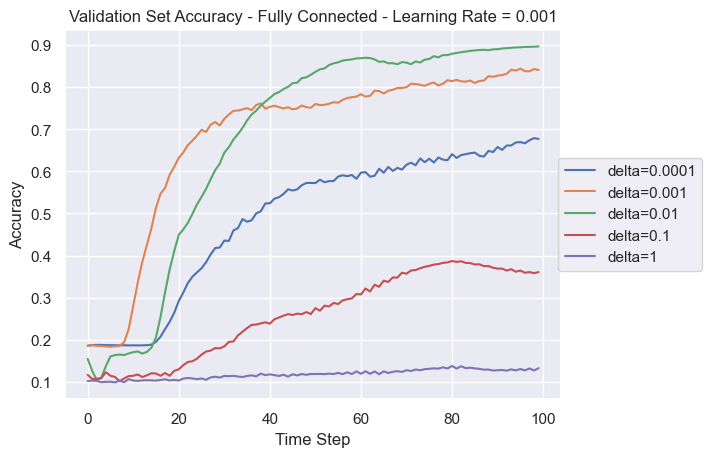

In [ ]:
T = range(t_max)
# Plot accuracies
lab = ['random', 'same']
for acc, rho in zip(acc_per_delta, rhos):
    plt.plot(T, acc, label=f'delta={rho}')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Time Step')
plt.ylabel('Accuracy')
plt.title('Validation Set Accuracy - Fully Connected - Learning Rate = 0.001')
plt.show()

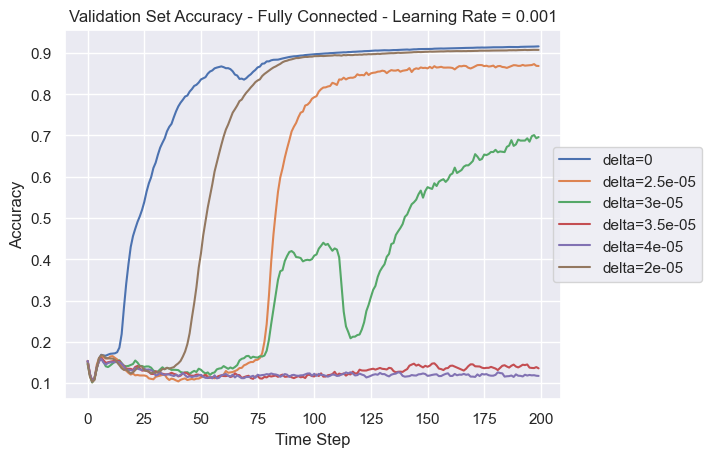

In [ ]:
T = range(t_max)
# Plot accuracies
for acc, delta in zip(acc_per_delta, deltas):
    plt.plot(T, acc, label=f'delta={delta}')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Time Step')
plt.ylabel('Accuracy')
plt.title('Validation Set Accuracy - Fully Connected - Learning Rate = 0.001')
plt.show()

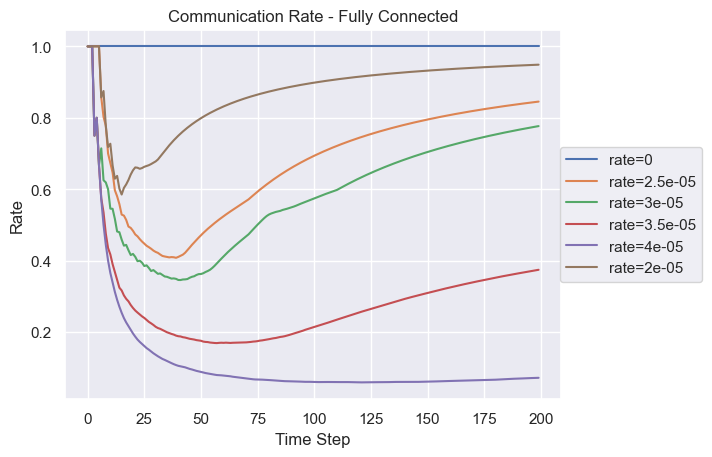

In [ ]:
for rate, delta in zip(rate_per_delta, deltas):
    plt.plot(T, rate, label=f'rate={delta}')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Time Step')
plt.ylabel('Rate')
plt.title('Communication Rate - Fully Connected')
plt.show()

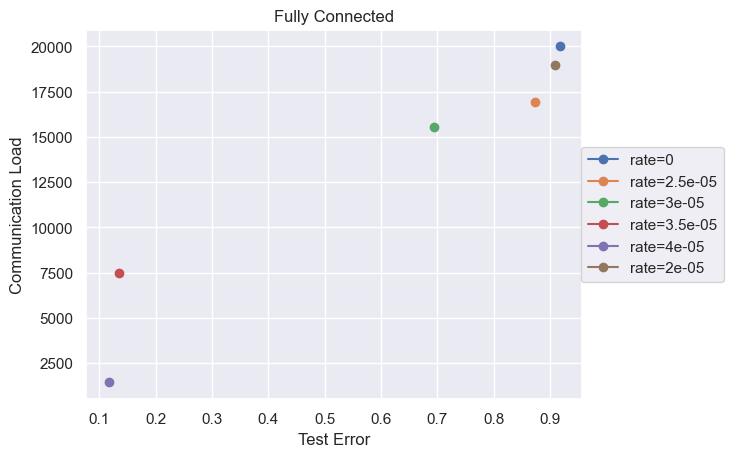

In [ ]:
for load, acc, delta in zip(loads, test_accs, deltas):
    plt.plot(acc, load, label=f'rate={delta}', marker='o')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Test Error')
plt.ylabel('Communication Load')
plt.title('Fully Connected')
plt.show()

In [ ]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import ExponentialPartitioner, NaturalIdPartitioner, LinearPartitioner

nodes = 3
fds = FederatedDataset(dataset='cifar10', partitioners={'train': nodes, 'test': 1})
partitions = [fds.load_partition(node_id=node, split='train') for node in range(nodes)]

transforms = ToTensor()
def apply_transforms(batch):
  batch["img"] = [transforms(img) for img in batch["img"]]
  return batch

partitions_torch = [partition.with_transform(apply_transforms) for partition in partitions]

print('Training partitions')
for i, partition in enumerate(partitions):
    print(f'\nPartition {i}')
    b= []
    for i in range(10):
        a = [1 for label in partition['label'] if label == i]
        b.append(sum(a))
        a = []
    print(b)

print('\nTest partition\n')
partition = fds.load_partition(node_id=0, split='test')
b= []
for i in range(10):
    a = [1 for label in partition['label'] if label == i]
    b.append(sum(a))
    a = []
print(b)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Training partitions

Partition 0
[1705, 1605, 1682, 1628, 1669, 1683, 1674, 1692, 1643, 1686]

Partition 1
[1599, 1723, 1659, 1729, 1670, 1647, 1679, 1644, 1653, 1664]

Partition 2
[1696, 1672, 1659, 1643, 1661, 1670, 1647, 1664, 1704, 1650]

Test partition

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
